In [1]:
import torch
import PIL
from torchvision.transforms import ToPILImage
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch.nn.functional as nnf
import evaluate
from torchvision import transforms
import numpy as np

2023-11-29 13:15:34.739891: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 13:15:34.739939: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 13:15:34.739994: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
ade20k_dino = load_dataset("danjacobellis/ade20k_dino",split='validation').with_format("torch")

In [3]:
ade20k = load_dataset("scene_parse_150",split='validation')

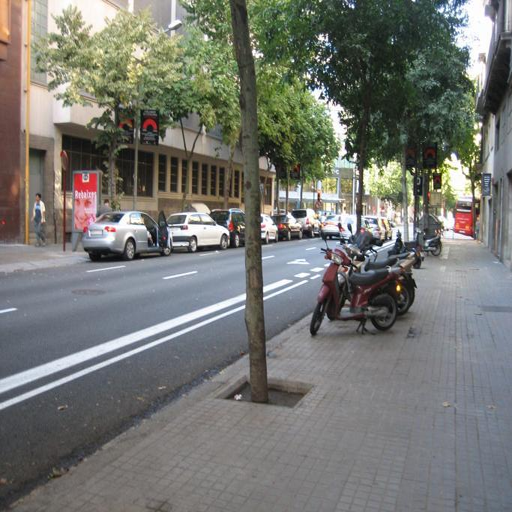

In [4]:
ade20k[0]['image'].resize((512,512))

In [5]:
x = ade20k_dino[0]['patch_tokens'].reshape((1,16,16,1536)).permute((0,3,1,2))

/tmp/ipykernel_5475/2871694322.py:6: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  display(ToPILImage()(z).resize((64,64),PIL.Image.NEAREST))


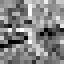

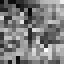

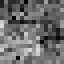

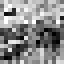

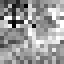

In [6]:
for c in range(5):
    z = x[0,c,:,:]
    z = z.clamp(-3,3)
    z = z/6 + 0.5
    z = (255*z).round().to(torch.uint8)
    display(ToPILImage()(z).resize((64,64),PIL.Image.NEAREST))

In [7]:
import torch
import torch.nn as nn

class LinearSegmentationHead(nn.Module):
    def __init__(self, in_channels=1536, num_classes=150):
        super(LinearSegmentationHead, self).__init__()
        self.conv_seg = nn.Conv2d(in_channels, num_classes, kernel_size=1)
        self.bn = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        x = self.bn(x)
        x = self.conv_seg(x)
        return x


In [8]:
checkpoint = torch.load("dinov2_vitg14_ade20k_linear_head.pth")
new_state_dict = {key.replace("decode_head.", ""): value for key, value in checkpoint['state_dict'].items()}
model = LinearSegmentationHead()
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [9]:
x.shape

torch.Size([1, 1536, 16, 16])

In [10]:
y = nnf.interpolate(x, size=(512, 512), mode='bicubic', align_corners=True)

In [11]:
z = model(y).argmax(dim=1)

In [12]:
model(y).shape

torch.Size([1, 150, 512, 512])

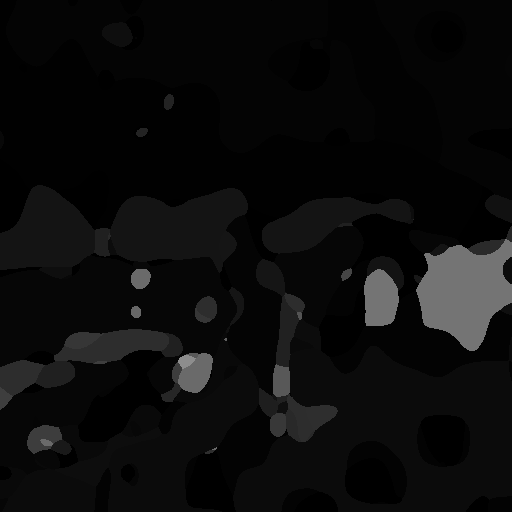

In [13]:
ToPILImage()(z[0].to(torch.uint8))

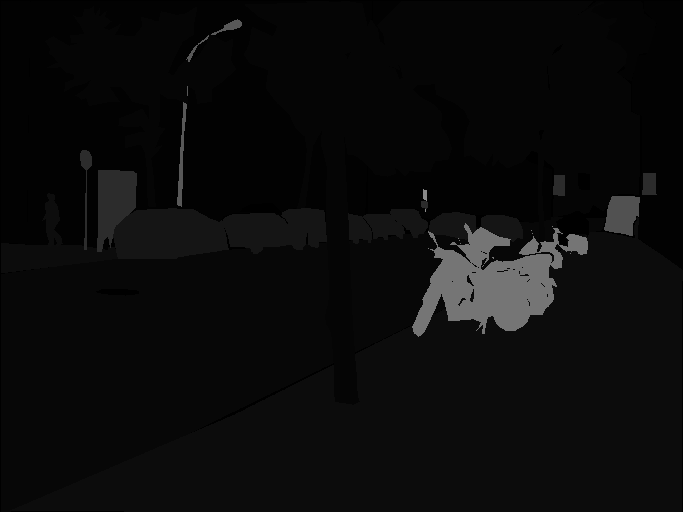

In [14]:
ade20k[0]['annotation']

In [15]:
mean_iou = evaluate.load("mean_iou")

In [ ]:
# %%time

# model = model.cpu()
model = model.cuda()

x = []
y = []

for i_sample,sample in enumerate(ade20k):
    ground_truth = sample['annotation']
    h = ground_truth.height
    w = ground_truth.width

    with torch.no_grad():
        input = ade20k_dino[i_sample]['patch_tokens'].reshape((1,16,16,1536)).permute((0,3,1,2))
        if h>1000:
            input = nnf.interpolate(input, size=(h//2, w//2), mode='bicubic', align_corners=True)
            input = input.to("cuda")
            logits = model(input).detach().cpu()  # shape (batch_size, num_labels, height/2, width/2)
            logits = nnf.interpolate(logits, size=(h, w), mode='bicubic', align_corners=True)
        else:
            input = nnf.interpolate(input, size=(h, w), mode='bicubic', align_corners=True)
            input = input.to("cuda")
            logits = model(input).detach().cpu()  # shape (batch_size, num_labels, height, width)
        predictions = logits.argmax(dim=1)[0].to(torch.uint8)
    
        x.append(np.array(ground_truth))
        y.append(np.array(predictions))

In [ ]:
%%time
results = mean_iou.compute(
    predictions=y,
    references=x,
    num_labels=150,
    ignore_index=0,
    reduce_labels=True
)

In [ ]:
torch.save(results,"results.pt")